In [68]:
# Standard libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

# For coord projections
import pyproj

# For plotting (maps)
# import pygmt
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt

# For processing gravity data
import verde as vd
import boule as bl
import harmonica as hm

#for a nice jupyter notebook
from IPython.display import Markdown

#own functions
from plotting_functions import plot_gravity_comparison



### Import gravity disturbance and geoid heights data from ICGEM and bathymetry data from GEBCO
Bathymetry; GEBCO https://download.gebco.net with 15 arc-second resolution <br>
Gravity: https://icgem.gfz-potsdam.de/calcgrid with 1 arc-minute resolution <br>
GEOID: https://icgem.gfz-potsdam.de/calcgrid with 15 arc-second resolution

In [2]:
# path_bathymetry = './F7_2024.nc'
path_bathymetry = './GEBCO_21_Apr_2025_13c681bd1663/gebco_2024_n36.8_s36.2_w25.2_e25.8.nc'
path_gravity = './gravity_disturbance.gdf'
path_geoid = './geoid_EIGEN-6C4_8088687efbc6f51a0d942bc3bc52cdac608c0faf99ec6a1ca557b4e4c4eaf087.gdf'

In [3]:
bathymetry_data = xr.open_dataset(path_bathymetry)

gravity_dataset = hm.load_icgem_gdf(path_gravity)

geoid_dataset = hm.load_icgem_gdf(path_geoid)

### Crop bathymetry, data and uncertainties to area of interest around Kolumbo volcano

In [4]:
# West, East, South, North (degrees)
region = (25.35,25.63,36.41,36.64)
# Pad the region for slicing the grids
region_pad_bathy = vd.pad_region(region, pad=0.4)
region_pad_geoid = vd.pad_region(region, pad=0.2)

gravity_dataset = gravity_dataset.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))
bathymetry_data = bathymetry_data.sel(lon=slice(*region_pad_bathy[:2]), lat=slice(*region_pad_bathy[2:]))
geoid_dataset = geoid_dataset.sel(longitude=slice(*region_pad_geoid[:2]), latitude=slice(*region_pad_geoid[2:]))

In [5]:
grav = gravity_dataset.gravity_disturbance
meas_height_geoid = gravity_dataset.h_over_geoid
bathymetry_geoid = bathymetry_data.elevation
geoid_height = geoid_dataset.geoid

### Project the bathymetry and gravity data from geographic to Mercator system

In [66]:
projection = pyproj.Proj(proj="merc", lat_ts=gravity_dataset.latitude.values.mean())

# use verde to create an evenly spaced grid in Mercator projection
grav_proj = vd.project_grid(grav, projection, method='nearest') 
meas_height_geoid_proj = vd.project_grid(meas_height_geoid, projection, method='nearest') 
bathy_geoid_proj = vd.project_grid(bathymetry_geoid, projection, method='nearest') 
geoid_height_proj = vd.project_grid(geoid_height, projection, method='nearest')

/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x1106e3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function mean at 0x1106e3600> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x1106e3600> is currently using DataFrameGroupBy.mean. In a future version

### Reference topography and measurements to height above the reference ellipsoid instead of height above the geoid

In [ ]:
#make meshgrid from gravity easting and northing values (use indexing='ij' to keep the matrix-style indexing)
grav_north, grav_east = np.meshgrid(meas_height_geoid_proj.northing.values, meas_height_geoid_proj.easting.values, indexing='ij')
bathy_north, bathy_east = np.meshgrid(bathy_geoid_proj.northing.values, bathy_geoid_proj.easting.values, indexing='ij')
geoid_east, geoid_north = np.meshgrid(geoid_height_proj.easting, geoid_height_proj.northing, indexing='ij')

In [10]:
geoid_interpolator = RegularGridInterpolator((geoid_height_proj.northing, geoid_height_proj.easting),geoid_height_proj.values, bounds_error=False, fill_value = None)

bathy_points = np.stack([bathy_north.ravel(), bathy_east.ravel()], axis=-1)

geoid_at_bathy = geoid_interpolator(bathy_points).reshape(bathy_geoid_proj.shape)
bathymetry_ellips = bathy_geoid_proj + geoid_at_bathy

grav_points = np.stack([grav_north.ravel(), grav_east.ravel()], axis=-1)
geoid_at_meas = geoid_interpolator(grav_points).reshape(meas_height_geoid_proj.shape)
meas_height_ellips = meas_height_geoid_proj + geoid_at_meas

Check if projections worked:

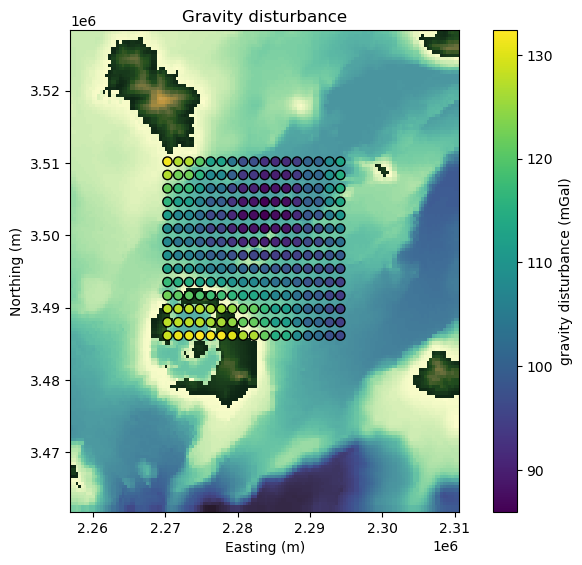

In [35]:
plt.figure(figsize=(7, 6))
pc = bathy_geoid_proj.plot.pcolormesh(cmap=cmocean.cm.topo, add_colorbar=False)
sc = plt.scatter(grav_east, grav_north, c=grav_proj, s=45, edgecolor='black')
plt.colorbar(sc).set_label("gravity disturbance (mGal)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at top for title
plt.title("Gravity disturbance")

plt.show()

### Topographic correction with Harmonica package

In [12]:
# CRUST1.0 - model: https://ds.iris.edu/ds/products/emc-crust10/
path_crust1 = './CRUST1.0-rho.r0.1.nc'
crust1_model = xr.open_dataset(path_crust1)
# West, East, South, North (degrees)
region = (25.35,25.63,36.41,36.64)
crust1_model = crust1_model.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))

In [13]:
# densities from the CRUST1.0 model in g/cm^3 transformed into kg/m^3
density_crust_kolumbo = crust1_model.upper_crust_rho.values[0,0]*1e3
density_sea_kolumbo = crust1_model.water_rho.values[0,0]*1e3

In [14]:
markdown_content = f"""
Assigning the following density (contrasts) to the model (from CRUST1.0 model (https://ds.iris.edu/ds/products/emc-crust10/)):
* $\\rho = {density_crust_kolumbo:.2f} \\; \\text{{kg/m}}^3$: crust above the ellipsoid
* $\\rho = -{density_crust_kolumbo:.2f} \\; \\text{{kg/m}}^3$: crust below the ellipsoid (none on land in this region)
* $\\rho = {density_sea_kolumbo:.2f} - {density_crust_kolumbo:.2f} = {density_sea_kolumbo-density_crust_kolumbo:.2f} \\; \\text{{kg/m}}^3$: in the ocean (density of the ocean minus density of the crust)
"""

Markdown(markdown_content)


Assigning the following density (contrasts) to the model (from CRUST1.0 model (https://ds.iris.edu/ds/products/emc-crust10/)):
* $\rho = 2720.00 \; \text{kg/m}^3$: crust above the ellipsoid
* $\rho = -2720.00 \; \text{kg/m}^3$: crust below the ellipsoid (none on land in this region)
* $\rho = 1020.00 - 2720.00 = -1700.00 \; \text{kg/m}^3$: in the ocean (density of the ocean minus density of the crust)


In [15]:
#assigning crustal densities above and below the ellipsoid (positive is UP for this bathymetry data)
bathymetry_density = np.where(bathymetry_ellips > 0, density_crust_kolumbo, -density_crust_kolumbo)
# assign values for density deficit in the sea (at locations, where  )
bathymetry_density = np.where(bathy_geoid_proj < 0, density_sea_kolumbo - density_crust_kolumbo, bathymetry_density)
# Create the prism model of the topographic masses
topography_model = hm.prism_layer(
    coordinates=(bathymetry_ellips.easting, bathymetry_ellips.northing),
    surface=bathymetry_ellips,
    reference=0,
    properties={"density": bathymetry_density}
)

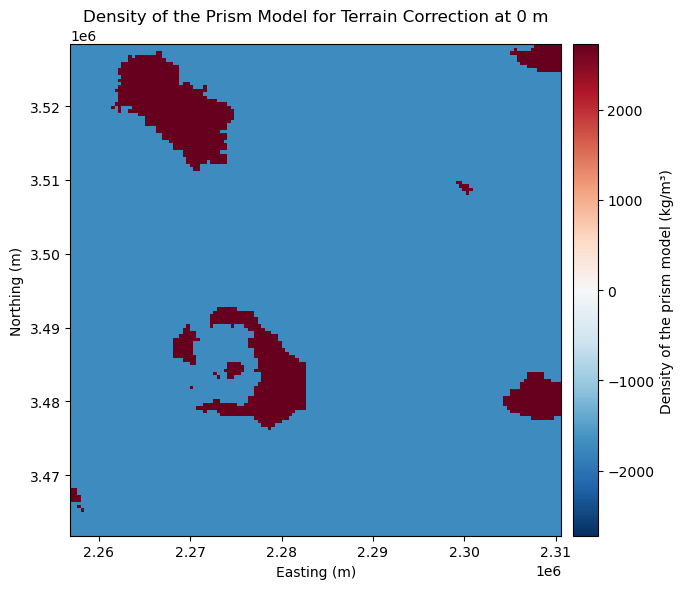

In [16]:
scale = np.max(np.abs(topography_model.density))  # Maximum absolute value for symmetric color scale

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7,6))

# Plot the density data as a colormesh
cmesh = ax.pcolormesh(
    topography_model.easting,
    topography_model.northing,
    topography_model.density,
    cmap="RdBu_r",  # Diverging colormap similar to "roma+h"
    shading="auto",
    vmin=-scale,
    vmax=scale,
)

# Add a colorbar
cbar = fig.colorbar(cmesh, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Density of the prism model (kg/m³)")

# Set axis labels and title
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Density of the Prism Model for Terrain Correction at 0 m")

# Show the plot
plt.tight_layout()
plt.show()

Forward modeling of the bathymetric/topographic gravational effect at the data points. Removing this effect from the initial gravity disturbance yields the Bourguer disturbance.

In [17]:
coordinates = (grav_east, grav_north, meas_height_ellips.values)
terrain_effect_mgal = topography_model.prism_layer.gravity(coordinates, field="g_z")

gravity_bouguer_mgal = grav_proj - terrain_effect_mgal

Plot the Bouguer gravity disturbance next to initial gravity disturbance

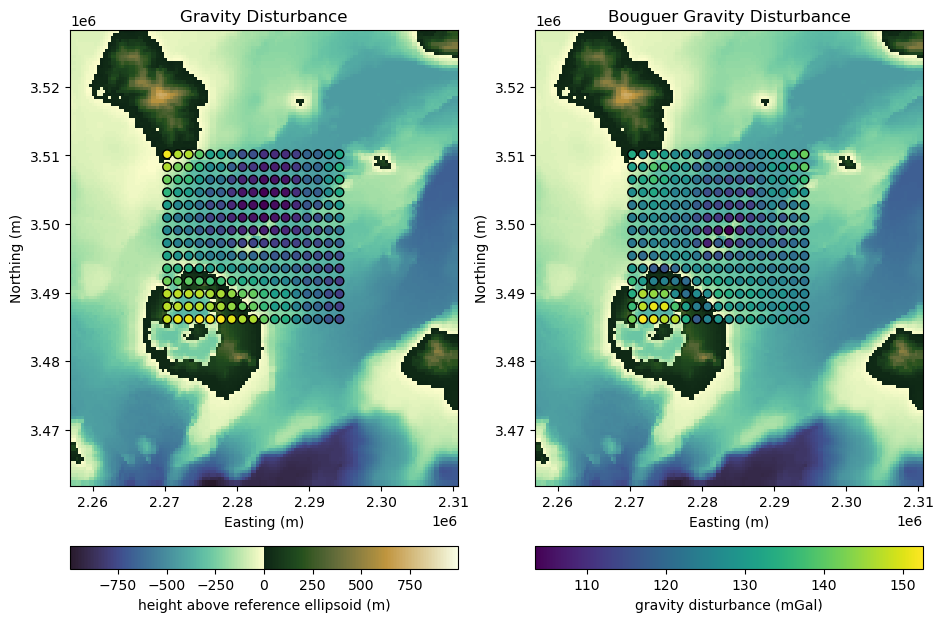

In [18]:
fig = plot_gravity_comparison(
    bathymetry_ellips,
    grav_east,
    grav_north,
    grav_proj,
    gravity_bouguer_mgal,
    cbar1_label="height above reference ellipsoid (m)",
    cbar2_label="gravity disturbance (mGal)",
    title1="Gravity Disturbance",
    title2="Bouguer Gravity Disturbance"
)
plt.show()

## Remove regional gravity field with Harmonica package

In [19]:
# Moho depth (from CRUST1.0 model): 
moho_depth_geoid = crust1_model.mantle_top.values[0,0]*1e3 # mantle top relative to sea level in km, transformed to m
moho_depth_ellips = moho_depth_geoid + geoid_height[0,0].values # mantle top relative to reference ellipsoid

In [20]:
# Create a set of deep sources at depth of Moho
deep_sources = hm.EquivalentSources(damping=1000, depth=-moho_depth_ellips)
# Fit the sources to the data
deep_sources.fit((grav_east, grav_north, meas_height_ellips.values), gravity_bouguer_mgal)

# Use the sources to predict the regional field
gravity_regional_mgal = deep_sources.predict((grav_east, grav_north, meas_height_ellips.values))

# Calculate a residual field 
gravity_residual_mgal = gravity_bouguer_mgal - gravity_regional_mgal


/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_31286/27897678.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


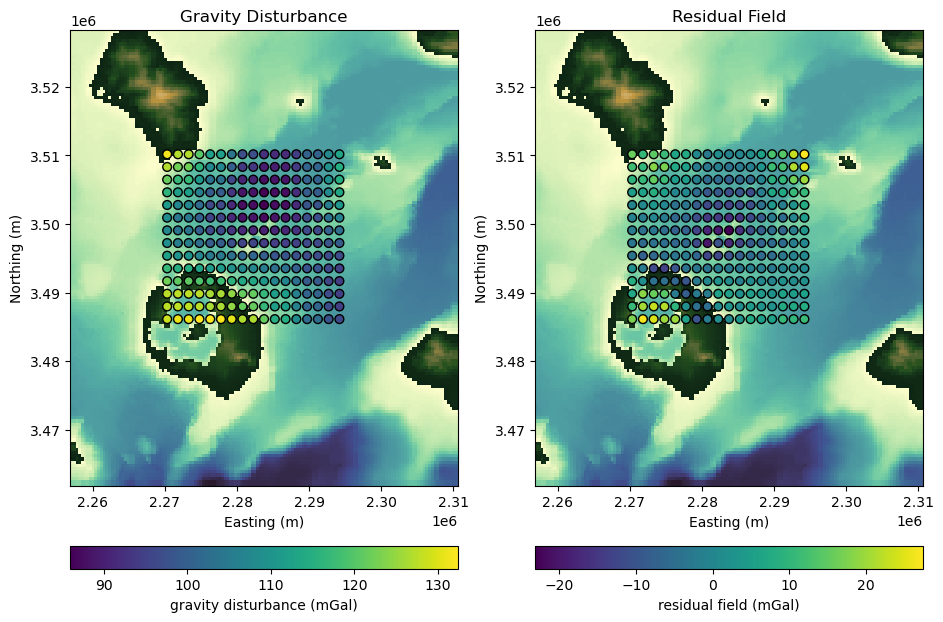

In [23]:
fig = plot_gravity_comparison(
    bathymetry_ellips,
    grav_east,
    grav_north,
    grav_proj,
    gravity_residual_mgal,
    shared_cbar=False,
    cbar1_data='scatter',
    cbar2_data='scatter',
    cbar1_label="gravity disturbance (mGal)",
    cbar2_label="residual field (mGal)",
    title1="Gravity Disturbance",
    title2="Residual Field"
)

fig.show()